In [6]:
import time
import warnings

import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, HTML
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.quantum_info import Statevector
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 420

from autoenc import ansatz, auto_encoder_circuit
from utils import get_dataset_digits, get_dataset_cifar

# RUN THIS CELL ONLY TO DOWNLOAD CIFAR

In [3]:
# Define transform to convert images to grayscale
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Download and load CIFAR10 dataset
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)

num_images = 8
subset = list(range(0, len(trainset), int(len(trainset)/num_images))) 
trainset = torch.utils.data.Subset(trainset, subset)
trainset = list(map(
    lambda x: (x[0].type(torch.float16).flatten().numpy(), x[1]), 
    trainset
))

print(f"We have {len(trainset)} samples of type {type(trainset[0][0])}")

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,shuffle=True)

Files already downloaded and verified
We have 8 samples of type <class 'numpy.ndarray'>


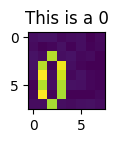

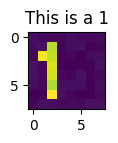

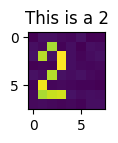

torch.Size([3, 64])


In [4]:
train_images, __ = get_dataset_digits(2)
print(torch.tensor(train_images).shape)

In [7]:
train_images, __ = get_dataset_cifar(2, trainset)
print(train_images.shape)

(8, 1024)


Using 1024 FeatureMap & 1010 AutoEncoder


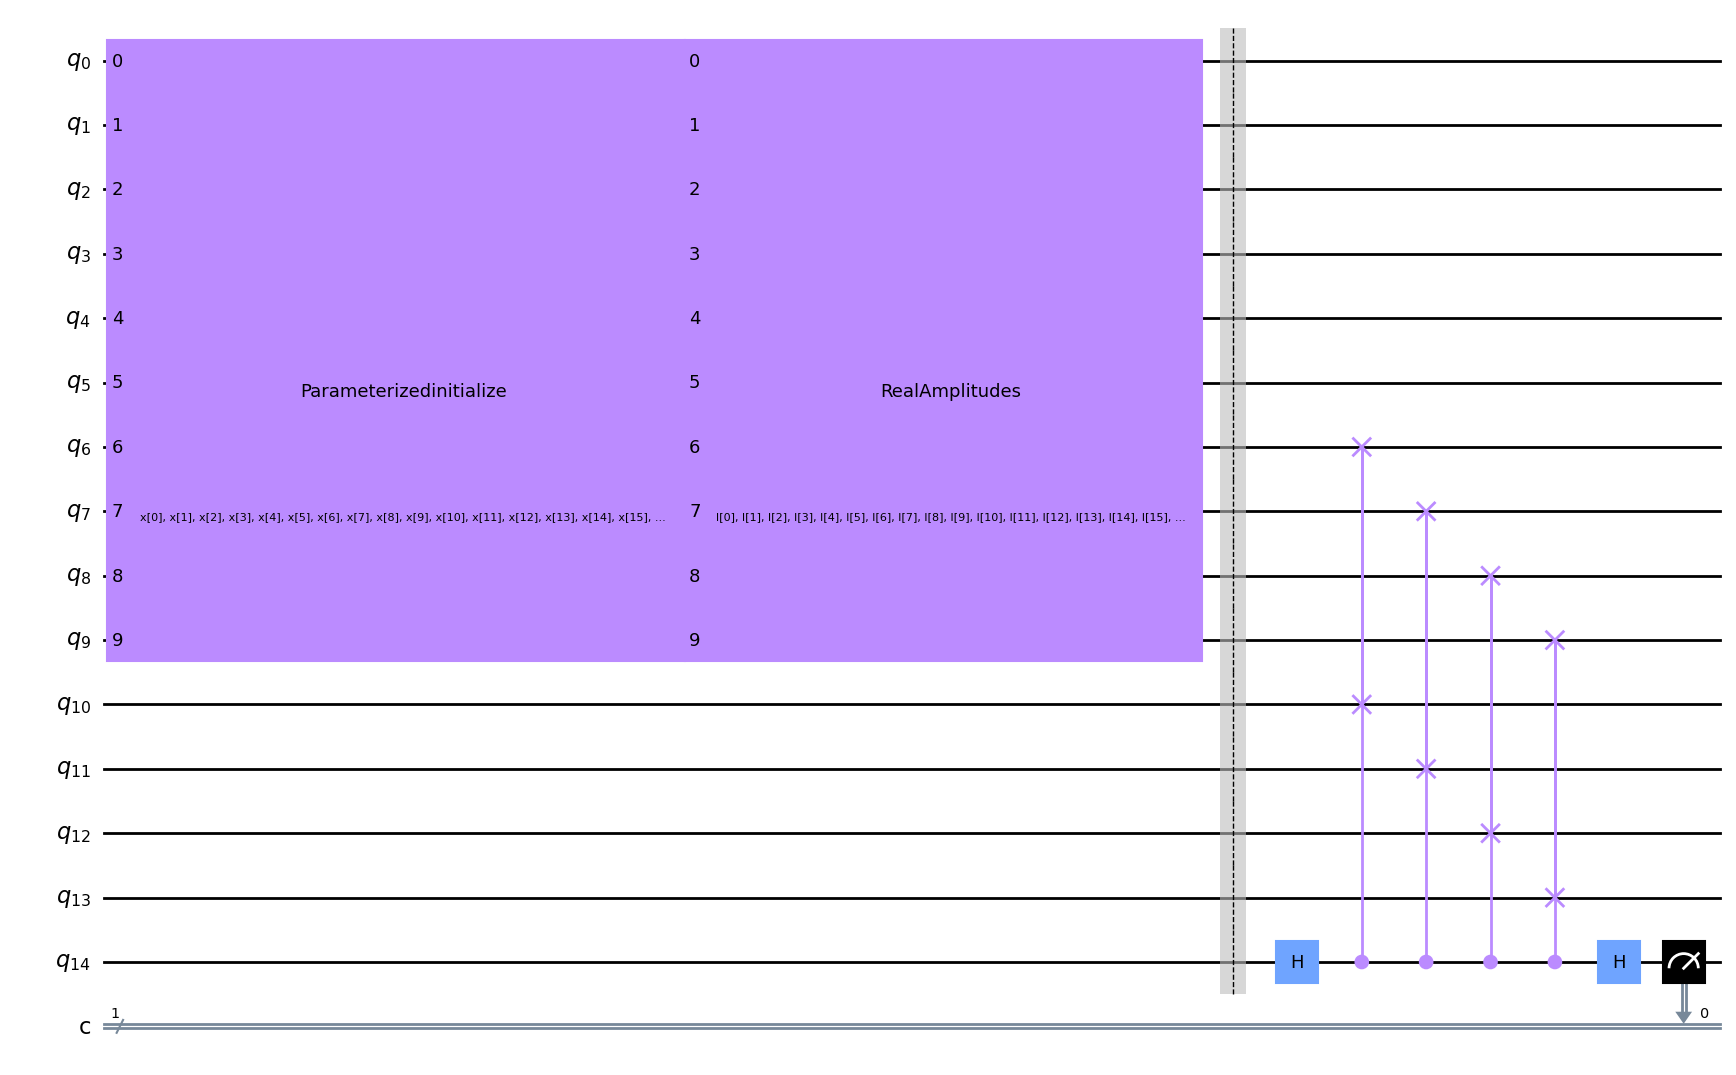

In [8]:
num_latent = 6
num_trash = 4

dimension = 2 ** (num_latent + num_trash)
fm = RawFeatureVector(dimension)

ae = auto_encoder_circuit(num_latent, num_trash)

# Latent + 2Trash + 1
qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

print(f"Using {len(fm.parameters)} FeatureMap & {len(ae.parameters)} AutoEncoder")

qc.draw("mpl")

Again, we can see the swap test being performed on the qubits $3$, $4$, $5$ and $6$, which will determine the value of our cost function.

In [9]:
def identity(x):
    return x

qnn = SamplerQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity,
    output_shape=2,
)

In [10]:
def cost_func_digits(params_values):
    probabilities = qnn.forward(train_images, params_values)
    cost = np.sum(probabilities[:, 1]) / train_images.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

In [11]:
initial_point = [np.random.rand() for i in range(len(ae.parameters))]

In [ ]:
opt = COBYLA(maxiter=600)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_digits, x0=initial_point)
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

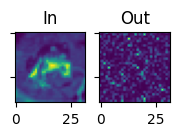

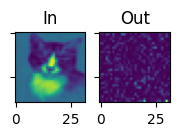

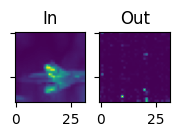

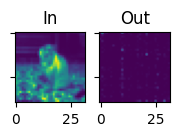

In [20]:
# Test
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

# sample new images
test_images, test_labels = get_dataset_cifar(2, draw=False)
for image, label in zip(test_images, test_labels):
    original_qc = fm.assign_parameters(image)
    original_sv = Statevector(original_qc).data
#     original_sv = np.reshape(np.abs(original_sv) ** 2, (8, 8))
    original_sv = np.reshape(np.abs(original_sv) ** 2, (32, 32))


    param_values = np.concatenate((image, opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    output_sv = np.reshape(np.abs(output_sv) ** 2, (32,32))

    plt.rcParams["figure.figsize"] = (2, 1)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_yticklabels([])
    ax2.set_yticklabels([])
        
    ax1.imshow(original_sv)
    ax1.set_title("In")
    ax2.imshow(output_sv)
    ax2.set_title("Out")
    plt.show()

In [2]:
HTML("""
<style>
html{filter:invert(1)}

div.prompt{opacity: 0.5;}

.btn-default{border-color: transparent;}

#header-container{display:none !important;}

div.cell.selected, div.cell.selected.jupyter-soft-selected{border-color: transparent;}
</style>
""")